In [1]:
#=================================================================
#============ Enhanced KMeans with Interaction Analysis ==========
#=================================================================

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Union
import logging
from itertools import combinations
import networkx as nx

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, euclidean
from scipy.signal import savgol_filter
from scipy.stats import zscore, pearsonr
from scipy.ndimage import gaussian_filter1d

import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
class PoseFeatureExtractor:
    """Extract meaningful features from pose keypoints"""
    
    def __init__(self):
        self.joint_pairs = {
            'left_arm_angle': ['LeftShoulder', 'LeftElbow', 'LeftWrist'],
            'right_arm_angle': ['RightShoulder', 'RightElbow', 'RightWrist'],
            'left_leg_angle': ['LeftHip', 'LeftKnee', 'LeftAnkle'],
            'right_leg_angle': ['RightHip', 'RightKnee', 'RightAnkle'],
            'torso_angle': ['Neck', 'MidHip'],
        }
        
        self.distance_pairs = {
            'shoulder_width': ['LeftShoulder', 'RightShoulder'],
            'hip_width': ['LeftHip', 'RightHip'],
            'torso_length': ['Neck', 'MidHip'],
            'left_arm_length': ['LeftShoulder', 'LeftWrist'],
            'right_arm_length': ['RightShoulder', 'RightWrist'],
        }
    
    def calculate_angle(self, p1: np.ndarray, p2: np.ndarray, p3: np.ndarray) -> float:
        """Calculate angle at p2 formed by p1-p2-p3"""
        v1 = p1 - p2
        v2 = p3 - p2
        
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        angle = np.arccos(cos_angle)
        return np.degrees(angle)
    
    def calculate_distance(self, p1: np.ndarray, p2: np.ndarray) -> float:
        """Calculate Euclidean distance between two points"""
        return np.linalg.norm(p1 - p2)
    
    def extract_basic_features(self, df_pivot: pd.DataFrame) -> pd.DataFrame:
        """Extract basic X,Y coordinate features"""
        return df_pivot.copy()
    
    def extract_angle_features(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Extract joint angle features"""
        angle_features = []
        
        for frame in joint_positions['Frame'].unique():
            frame_data = joint_positions[joint_positions['Frame'] == frame]
            frame_features = {'Frame': frame}
            
            for angle_name, joints in self.joint_pairs.items():
                if len(joints) == 3:
                    try:
                        points = []
                        for joint in joints:
                            joint_data = frame_data[frame_data['Joint'] == joint]
                            if not joint_data.empty:
                                points.append(np.array([joint_data['X'].iloc[0], joint_data['Y'].iloc[0]]))
                        
                        if len(points) == 3:
                            angle = self.calculate_angle(points[0], points[1], points[2])
                            frame_features[f'angle_{angle_name}'] = angle
                    except:
                        frame_features[f'angle_{angle_name}'] = np.nan
                elif len(joints) == 2:  # For torso angle
                    try:
                        points = []
                        for joint in joints:
                            joint_data = frame_data[frame_data['Joint'] == joint]
                            if not joint_data.empty:
                                points.append(np.array([joint_data['X'].iloc[0], joint_data['Y'].iloc[0]]))
                        
                        if len(points) == 2:
                            # Calculate angle with vertical
                            vertical = np.array([0, -1])  # Assuming Y increases downward
                            direction = points[1] - points[0]
                            direction = direction / (np.linalg.norm(direction) + 1e-8)
                            angle = np.arccos(np.clip(np.dot(direction, vertical), -1.0, 1.0))
                            frame_features[f'angle_{angle_name}'] = np.degrees(angle)
                    except:
                        frame_features[f'angle_{angle_name}'] = np.nan
            
            angle_features.append(frame_features)
        
        return pd.DataFrame(angle_features)
    
    def extract_distance_features(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Extract distance-based features"""
        distance_features = []
        
        for frame in joint_positions['Frame'].unique():
            frame_data = joint_positions[joint_positions['Frame'] == frame]
            frame_features = {'Frame': frame}
            
            for dist_name, joints in self.distance_pairs.items():
                try:
                    points = []
                    for joint in joints:
                        joint_data = frame_data[frame_data['Joint'] == joint]
                        if not joint_data.empty:
                            points.append(np.array([joint_data['X'].iloc[0], joint_data['Y'].iloc[0]]))
                    
                    if len(points) == 2:
                        distance = self.calculate_distance(points[0], points[1])
                        frame_features[f'dist_{dist_name}'] = distance
                except:
                    frame_features[f'dist_{dist_name}'] = np.nan
            
            distance_features.append(frame_features)
        
        return pd.DataFrame(distance_features)
    
    def extract_temporal_features(self, features_df: pd.DataFrame, window_size: int = 5) -> pd.DataFrame:
        """Extract temporal features like velocity and acceleration"""
        temporal_features = features_df.copy()
        
        # Smooth features first
        feature_cols = [col for col in features_df.columns if col != 'Frame']
        
        for col in feature_cols:
            if temporal_features[col].notna().sum() > window_size:
                # Apply smoothing
                valid_mask = temporal_features[col].notna()
                if valid_mask.sum() > window_size:
                    smoothed = savgol_filter(
                        temporal_features.loc[valid_mask, col].values, 
                        window_length=min(window_size, valid_mask.sum()//2*2+1), 
                        polyorder=2
                    )
                    temporal_features.loc[valid_mask, f'{col}_smoothed'] = smoothed
                
                # Calculate velocity (first derivative)
                temporal_features[f'{col}_velocity'] = temporal_features[col].diff()
                
                # Calculate acceleration (second derivative)
                temporal_features[f'{col}_acceleration'] = temporal_features[f'{col}_velocity'].diff()
        
        return temporal_features
    
class PoseClusteringValidator:
    """Validate clustering results and determine optimal parameters"""
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.optimal_k = None
        self.silhouette_scores = {}
        self.inertia_scores = {}
    
    def find_optimal_clusters(self, X: np.ndarray, k_range: range = range(2, 8)) -> Dict:
        """Find optimal number of clusters using multiple metrics"""
        results = {
            'silhouette_scores': [], 
            'inertia_scores': [],
            'k_values': list(k_range)
        }
#The silhouette score -how well a data point fits within its assigned cluster, compared to other clusters.
#The inertia - how tightly packed the points in a cluster are; the sum of squared distances from each point to its cluster center.
        X_scaled = self.scaler.fit_transform(X)
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_scaled)
            
            # Silhouette score
            sil_score = silhouette_score(X_scaled, labels)
            results['silhouette_scores'].append(sil_score)
            
            # Inertia (within-cluster sum of squares)
            results['inertia_scores'].append(kmeans.inertia_)
            
            logger.info(f"k={k}: Silhouette={sil_score:.3f}, Inertia={kmeans.inertia_:.1f}")
        
        # Find optimal k using silhouette score
        best_idx = np.argmax(results['silhouette_scores'])
        self.optimal_k = results['k_values'][best_idx]
        
        logger.info(f"Optimal k based on silhouette score: {self.optimal_k}")
        
        return results
    
    def plot_validation_metrics(self, results: Dict):
        """Plot validation metrics to help choose optimal k"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Silhouette scores
        ax1.plot(results['k_values'], results['silhouette_scores'], 'bo-')
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('Silhouette Score')
        ax1.set_title('Silhouette Analysis')
        ax1.grid(True, alpha=0.3)
        ax1.axvline(x=self.optimal_k, color='red', linestyle='--', alpha=0.7, 
                   label=f'Optimal k={self.optimal_k}')
        ax1.legend()
        
        # Elbow method
        ax2.plot(results['k_values'], results['inertia_scores'], 'ro-')
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Inertia')
        ax2.set_title('Elbow Method')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


class InteractionAnalyzer:
    """Analyze spatial and temporal interactions between individuals and objects"""
    
    def __init__(self, proximity_threshold: float = 100.0, 
                 temporal_window: int = 30, gaze_threshold: float = 45.0):
        """
        Initialize interaction analyzer
        
        Args:
            proximity_threshold: Distance threshold for proximity analysis (pixels)
            temporal_window: Window size for temporal co-occurrence analysis (frames)
            gaze_threshold: Angle threshold for gaze estimation (degrees)
        """
        self.proximity_threshold = proximity_threshold
        self.temporal_window = temporal_window
        self.gaze_threshold = gaze_threshold
        
        # Key body points for interaction analysis
        self.key_points = {
            'head': ['Nose', 'Neck'],
            'torso': ['Neck', 'MidHip'],
            'hands': ['LeftWrist', 'RightWrist'],
            'center_mass': ['Neck', 'MidHip', 'LeftShoulder', 'RightShoulder', 'LeftHip', 'RightHip']
        }
        
        # Object categories (can be extended based on detection system)
        self.object_categories = {
            'furniture': ['chair', 'table', 'bed', 'desk'],
            'medical': ['wheelchair', 'walker', 'crutches', 'medical_device'],
            'exercise': ['dumbbell', 'exercise_ball', 'mat', 'resistance_band'],
            'daily_living': ['cup', 'book', 'phone', 'remote']
        }
    
    def extract_person_centroids(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Extract person centroids for each frame"""
        centroids = []
        
        for patient in joint_positions['Patient'].unique():
            patient_data = joint_positions[joint_positions['Patient'] == patient]
            
            for frame in patient_data['Frame'].unique():
                frame_data = patient_data[patient_data['Frame'] == frame]
                
                # Calculate center of mass
                valid_joints = frame_data.dropna(subset=['X', 'Y'])
                if not valid_joints.empty:
                    centroid_x = valid_joints['X'].mean()
                    centroid_y = valid_joints['Y'].mean()
                    
                    centroids.append({
                        'Patient': patient,
                        'Frame': frame,
                        'Centroid_X': centroid_x,
                        'Centroid_Y': centroid_y
                    })
        
        return pd.DataFrame(centroids)
    
    def calculate_proximity_features(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Calculate proximity features between individuals"""
        centroids = self.extract_person_centroids(joint_positions)
        proximity_features = []
        
        patients = joint_positions['Patient'].unique()
        patient_pairs = list(combinations(patients, 2))
        
        for frame in centroids['Frame'].unique():
            frame_centroids = centroids[centroids['Frame'] == frame]
            frame_features = {'Frame': frame}
            
            # Calculate distances between all pairs
            for p1, p2 in patient_pairs:
                p1_data = frame_centroids[frame_centroids['Patient'] == p1]
                p2_data = frame_centroids[frame_centroids['Patient'] == p2]
                
                if not p1_data.empty and not p2_data.empty:
                    dist = euclidean(
                        [p1_data['Centroid_X'].iloc[0], p1_data['Centroid_Y'].iloc[0]],
                        [p2_data['Centroid_X'].iloc[0], p2_data['Centroid_Y'].iloc[0]]
                    )
                    
                    frame_features[f'distance_{p1}_{p2}'] = dist
                    frame_features[f'proximity_{p1}_{p2}'] = 1 if dist < self.proximity_threshold else 0
                    
                    # Calculate relative positioning
                    dx = p2_data['Centroid_X'].iloc[0] - p1_data['Centroid_X'].iloc[0]
                    dy = p2_data['Centroid_Y'].iloc[0] - p1_data['Centroid_Y'].iloc[0]
                    
                    angle = np.degrees(np.arctan2(dy, dx))
                    frame_features[f'relative_angle_{p1}_{p2}'] = angle
                    
                    # Spatial relationship categories
                    if abs(dx) > abs(dy):
                        relation = 'side_by_side' if dx > 0 else 'opposite_sides'
                    else:
                        relation = 'front_back' if dy > 0 else 'back_front'
                    
                    frame_features[f'spatial_relation_{p1}_{p2}'] = relation
            
            proximity_features.append(frame_features)
        
        return pd.DataFrame(proximity_features)
    
    def estimate_gaze_direction(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Estimate gaze direction based on head orientation"""
        gaze_features = []
        
        for patient in joint_positions['Patient'].unique():
            patient_data = joint_positions[joint_positions['Patient'] == patient]
            
            for frame in patient_data['Frame'].unique():
                frame_data = patient_data[patient_data['Frame'] == frame]
                frame_features = {'Patient': patient, 'Frame': frame}
                
                # Get head keypoints
                nose = frame_data[frame_data['Joint'] == 'Nose']
                neck = frame_data[frame_data['Joint'] == 'Neck']
                left_eye = frame_data[frame_data['Joint'] == 'LeftEye']
                right_eye = frame_data[frame_data['Joint'] == 'RightEye']
                
                if not nose.empty and not neck.empty:
                    # Head orientation vector
                    head_vector = np.array([
                        nose['X'].iloc[0] - neck['X'].iloc[0],
                        nose['Y'].iloc[0] - neck['Y'].iloc[0]
                    ])
                    
                    # Normalize and calculate angle
                    if np.linalg.norm(head_vector) > 0:
                        head_angle = np.degrees(np.arctan2(head_vector[1], head_vector[0]))
                        frame_features['gaze_angle'] = head_angle
                        
                        # Gaze direction categories
                        if -45 <= head_angle <= 45:
                            gaze_dir = 'right'
                        elif 45 < head_angle <= 135:
                            gaze_dir = 'down'
                        elif -135 <= head_angle < -45:
                            gaze_dir = 'up'
                        else:
                            gaze_dir = 'left'
                        
                        frame_features['gaze_direction'] = gaze_dir
                
                # Eye-based gaze estimation if available
                if not left_eye.empty and not right_eye.empty:
                    eye_center = np.array([
                        (left_eye['X'].iloc[0] + right_eye['X'].iloc[0]) / 2,
                        (left_eye['Y'].iloc[0] + right_eye['Y'].iloc[0]) / 2
                    ])
                    
                    if not nose.empty:
                        gaze_vector = np.array([
                            nose['X'].iloc[0] - eye_center[0],
                            nose['Y'].iloc[0] - eye_center[1]
                        ])
                        
                        if np.linalg.norm(gaze_vector) > 0:
                            refined_gaze_angle = np.degrees(np.arctan2(gaze_vector[1], gaze_vector[0]))
                            frame_features['refined_gaze_angle'] = refined_gaze_angle
                
                gaze_features.append(frame_features)
        
        return pd.DataFrame(gaze_features)
    
    def detect_interaction_events(self, proximity_df: pd.DataFrame, 
                                gaze_df: pd.DataFrame) -> pd.DataFrame:
        """Detect interaction events based on proximity and gaze"""
        interaction_events = []
        
        # Merge proximity and gaze data
        merged_data = proximity_df.copy()
        
        for frame in merged_data['Frame'].unique():
            frame_data = merged_data[merged_data['Frame'] == frame]
            frame_gaze = gaze_df[gaze_df['Frame'] == frame]
            
            frame_events = {'Frame': frame}
            
            # Check for proximity-based interactions
            proximity_cols = [col for col in frame_data.columns if col.startswith('proximity_')]
            for col in proximity_cols:
                if frame_data[col].iloc[0] == 1:  # In proximity
                    persons = col.replace('proximity_', '').split('_')
                    if len(persons) >= 2:
                        p1, p2 = persons[0], persons[1]
                        
                        # Check if they are facing each other
                        p1_gaze = frame_gaze[frame_gaze['Patient'] == p1]
                        p2_gaze = frame_gaze[frame_gaze['Patient'] == p2]
                        
                        interaction_type = 'proximity'
                        
                        if not p1_gaze.empty and not p2_gaze.empty:
                            if 'gaze_angle' in p1_gaze.columns and 'gaze_angle' in p2_gaze.columns:
                                angle_diff = abs(p1_gaze['gaze_angle'].iloc[0] - p2_gaze['gaze_angle'].iloc[0])
                                if angle_diff > 90:  # Roughly facing each other
                                    interaction_type = 'face_to_face'
                        
                        frame_events[f'interaction_{p1}_{p2}'] = interaction_type
            
            interaction_events.append(frame_events)
        
        return pd.DataFrame(interaction_events)
    
    def analyze_temporal_cooccurrence(self, interaction_events: pd.DataFrame) -> Dict:
        """Analyze temporal co-occurrence patterns"""
        cooccurrence_analysis = {}
        
        # Get interaction columns
        interaction_cols = [col for col in interaction_events.columns 
                          if col.startswith('interaction_')]
        
        for col in interaction_cols:
            # Extract person pair
            persons = col.replace('interaction_', '').split('_')
            if len(persons) >= 2:
                pair = f"{persons[0]}_{persons[1]}"
                
                # Analyze interaction patterns
                interaction_data = interaction_events[['Frame', col]].dropna()
                if not interaction_data.empty:
                    # Calculate interaction duration and frequency
                    interactions = interaction_data[interaction_data[col].notna()]
                    
                    if not interactions.empty:
                        cooccurrence_analysis[pair] = {
                            'total_interactions': len(interactions),
                            'interaction_frames': interactions['Frame'].tolist(),
                            'interaction_types': interactions[col].value_counts().to_dict(),
                            'interaction_duration_mean': self._calculate_interaction_durations(
                                interactions['Frame'].tolist()
                            )
                        }
        
        return cooccurrence_analysis
    
    def _calculate_interaction_durations(self, frames: List[int]) -> float:
        """Calculate mean interaction duration"""
        if len(frames) < 2:
            return 1.0
        
        durations = []
        current_duration = 1
        
        for i in range(1, len(frames)):
            if frames[i] - frames[i-1] == 1:  # Consecutive frames
                current_duration += 1
            else:
                durations.append(current_duration)
                current_duration = 1
        
        durations.append(current_duration)
        return np.mean(durations)
    
    def analyze_object_interactions(self, joint_positions: pd.DataFrame, 
                                  object_detections: Optional[pd.DataFrame] = None) -> pd.DataFrame:
        """
        Analyze human-object interactions
        
        Args:
            joint_positions: Joint position data
            object_detections: Optional object detection data with columns:
                              ['Frame', 'Object', 'X', 'Y', 'Width', 'Height', 'Confidence']
        """
        if object_detections is None:
            # Generate simulated object data for demonstration
            object_detections = self._generate_simulated_objects(joint_positions)
        
        object_interactions = []
        
        for patient in joint_positions['Patient'].unique():
            patient_data = joint_positions[joint_positions['Patient'] == patient]
            
            for frame in patient_data['Frame'].unique():
                frame_data = patient_data[patient_data['Frame'] == frame]
                frame_objects = object_detections[object_detections['Frame'] == frame]
                
                if frame_objects.empty:
                    continue
                
                frame_interactions = {'Patient': patient, 'Frame': frame}
                
                # Get hand positions
                left_hand = frame_data[frame_data['Joint'] == 'LeftWrist']
                right_hand = frame_data[frame_data['Joint'] == 'RightWrist']
                
                for _, obj in frame_objects.iterrows():
                    obj_center = (obj['X'] + obj['Width']/2, obj['Y'] + obj['Height']/2)
                    
                    # Check hand-object proximity
                    if not left_hand.empty:
                        left_dist = euclidean([left_hand['X'].iloc[0], left_hand['Y'].iloc[0]], obj_center)
                        frame_interactions[f"left_hand_to_{obj['Object']}_dist"] = left_dist
                        frame_interactions[f"left_hand_to_{obj['Object']}_interact"] = left_dist < 50
                    
                    if not right_hand.empty:
                        right_dist = euclidean([right_hand['X'].iloc[0], right_hand['Y'].iloc[0]], obj_center)
                        frame_interactions[f"right_hand_to_{obj['Object']}_dist"] = right_dist
                        frame_interactions[f"right_hand_to_{obj['Object']}_interact"] = right_dist < 50
                    
                    # Check gaze-object alignment (simplified)
                    person_centroid = self.extract_person_centroids(
                        patient_data[patient_data['Frame'] == frame]
                    )
                    if not person_centroid.empty:
                        person_pos = (person_centroid['Centroid_X'].iloc[0], 
                                    person_centroid['Centroid_Y'].iloc[0])
                        gaze_to_obj_dist = euclidean(person_pos, obj_center)
                        frame_interactions[f"gaze_to_{obj['Object']}_attention"] = gaze_to_obj_dist < 100
                
                object_interactions.append(frame_interactions)
        
        return pd.DataFrame(object_interactions)
    
    def _generate_simulated_objects(self, joint_positions: pd.DataFrame) -> pd.DataFrame:
        """Generate simulated object detections for demonstration"""
        np.random.seed(42)  # For reproducibility
        
        objects = []
        frames = joint_positions['Frame'].unique()
        
        # Simulate some common objects
        object_types = ['chair', 'table', 'cup', 'book']
        
        for frame in frames[::10]:  # Every 10th frame
            for obj_type in np.random.choice(object_types, size=np.random.randint(1, 3)):
                objects.append({
                    'Frame': frame,
                    'Object': obj_type,
                    'X': np.random.randint(50, 300),
                    'Y': np.random.randint(50, 300),
                    'Width': np.random.randint(30, 80),
                    'Height': np.random.randint(30, 80),
                    'Confidence': np.random.uniform(0.7, 0.95)
                })
        
        return pd.DataFrame(objects)

class SocialNetworkAnalyzer:
    """Analyze social network structure from interactions"""
    
    def __init__(self):
        self.interaction_graph = None
    
    def build_interaction_network(self, cooccurrence_data: Dict) -> nx.Graph:
        """Build social network graph from interaction data"""
        G = nx.Graph()
        
        for pair, data in cooccurrence_data.items():
            persons = pair.split('_')
            if len(persons) == 2:
                p1, p2 = persons[0], persons[1]
                
                # Add nodes
                G.add_node(p1)
                G.add_node(p2)
                
                # Add edge with interaction strength as weight
                interaction_strength = data['total_interactions']
                G.add_edge(p1, p2, weight=interaction_strength, 
                          interaction_data=data)
        
        self.interaction_graph = G
        return G
    
    def calculate_network_metrics(self, G: nx.Graph) -> Dict:
        """Calculate social network metrics"""
        metrics = {}
        
        if len(G.nodes) > 0:
            # Basic metrics
            metrics['num_nodes'] = len(G.nodes)
            metrics['num_edges'] = len(G.edges)
            metrics['density'] = nx.density(G)
            
            # Centrality measures
            if len(G.edges) > 0:
                metrics['degree_centrality'] = nx.degree_centrality(G)
                metrics['betweenness_centrality'] = nx.betweenness_centrality(G)
                metrics['closeness_centrality'] = nx.closeness_centrality(G)
            
            # Clustering
            metrics['clustering_coefficient'] = nx.clustering(G)
        
        return metrics
    
    def visualize_interaction_network(self, G: nx.Graph):
        """Visualize the interaction network"""
        if len(G.nodes) == 0:
            print("No interaction network to visualize")
            return
        
        plt.figure(figsize=(10, 8))
        
        # Position nodes
        pos = nx.spring_layout(G, k=1, iterations=50)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                              node_size=1000, alpha=0.7)
        
        # Draw edges with thickness proportional to interaction strength
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        max_weight = max(weights) if weights else 1
        
        for (u, v), weight in zip(edges, weights):
            nx.draw_networkx_edges(G, pos, [(u, v)], 
                                 width=5 * weight / max_weight,
                                 alpha=0.6)
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
        
        # Add edge labels with interaction counts
        edge_labels = {(u, v): f"{G[u][v]['weight']}" for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)
        
        plt.title("Social Interaction Network")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

class EnhancedPoseClassifier:
    """Enhanced pose classifier with interaction analysis"""
    
    def __init__(self):
        # Original components
        from __main__ import PoseFeatureExtractor, PoseClusteringValidator
        self.feature_extractor = PoseFeatureExtractor()
        self.validator = PoseClusteringValidator()
        self.scaler = StandardScaler()
        self.kmeans = None
        self.pca = PCA(n_components=2)
        
        # New interaction components
        self.interaction_analyzer = InteractionAnalyzer()
        self.social_analyzer = SocialNetworkAnalyzer()
        
        # Results storage
        self.interaction_results = {}
        self.social_metrics = {}
    
    def analyze_interactions(self, joint_positions: pd.DataFrame, 
                           object_detections: Optional[pd.DataFrame] = None) -> Dict:
        """Complete interaction analysis"""
        logger.info("Starting interaction analysis...")
        
        # 1. Proximity and spatial analysis
        proximity_features = self.interaction_analyzer.calculate_proximity_features(joint_positions)
        
        # 2. Gaze estimation
        gaze_features = self.interaction_analyzer.estimate_gaze_direction(joint_positions)
        
        # 3. Interaction event detection
        interaction_events = self.interaction_analyzer.detect_interaction_events(
            proximity_features, gaze_features)
        
        # 4. Temporal co-occurrence analysis
        cooccurrence_data = self.interaction_analyzer.analyze_temporal_cooccurrence(interaction_events)
        
        # 5. Object interaction analysis
        object_interactions = self.interaction_analyzer.analyze_object_interactions(
            joint_positions, object_detections)
        
        # 6. Social network analysis
        if cooccurrence_data:
            interaction_network = self.social_analyzer.build_interaction_network(cooccurrence_data)
            network_metrics = self.social_analyzer.calculate_network_metrics(interaction_network)
        else:
            interaction_network = None
            network_metrics = {}
        
        # Store results
        self.interaction_results = {
            'proximity_features': proximity_features,
            'gaze_features': gaze_features,
            'interaction_events': interaction_events,
            'cooccurrence_data': cooccurrence_data,
            'object_interactions': object_interactions,
            'social_network': interaction_network,
            'network_metrics': network_metrics
        }
        
        logger.info("Interaction analysis complete")
        return self.interaction_results
    
    def visualize_interaction_analysis(self):
        """Comprehensive visualization of interaction analysis"""
        if not self.interaction_results:
            logger.warning("No interaction results to visualize")
            return
        
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Proximity heatmap
        ax1 = plt.subplot(3, 3, 1)
        proximity_df = self.interaction_results['proximity_features']
        proximity_cols = [col for col in proximity_df.columns if col.startswith('distance_')]
        
        if proximity_cols:
            proximity_matrix = proximity_df[proximity_cols].fillna(0)
            sns.heatmap(proximity_matrix.T, cmap='viridis', ax=ax1)
            ax1.set_title('Proximity Heatmap Over Time')
            ax1.set_xlabel('Frame')
        
        # 2. Interaction timeline
        ax2 = plt.subplot(3, 3, 2)
        interaction_events = self.interaction_results['interaction_events']
        interaction_cols = [col for col in interaction_events.columns 
                          if col.startswith('interaction_')]
        
        if interaction_cols:
            for i, col in enumerate(interaction_cols[:3]):  # Show first 3
                interactions = interaction_events[interaction_events[col].notna()]
                if not interactions.empty:
                    ax2.scatter(interactions['Frame'], [i]*len(interactions), 
                              label=col.replace('interaction_', ''), alpha=0.7)
            ax2.set_title('Interaction Events Timeline')
            ax2.set_xlabel('Frame')
            ax2.set_ylabel('Interaction Type')
            ax2.legend()
        
        # 3. Social network visualization
        ax3 = plt.subplot(3, 3, 3)
        if self.interaction_results['social_network']:
            plt.sca(ax3)
            G = self.interaction_results['social_network']
            pos = nx.spring_layout(G)
            nx.draw(G, pos, with_labels=True, node_color='lightblue', 
                   node_size=1000, font_size=10, ax=ax3)
            ax3.set_title('Social Interaction Network')
        
        # 4. Gaze direction distribution
        ax4 = plt.subplot(3, 3, 4)
        gaze_df = self.interaction_results['gaze_features']
        if 'gaze_direction' in gaze_df.columns:
            gaze_counts = gaze_df['gaze_direction'].value_counts()
            gaze_counts.plot(kind='bar', ax=ax4)
            ax4.set_title('Gaze Direction Distribution')
            ax4.set_xlabel('Direction')
            ax4.set_ylabel('Count')
        
        # 5. Object interaction summary
        ax5 = plt.subplot(3, 3, 5)
        obj_interactions = self.interaction_results['object_interactions']
        interact_cols = [col for col in obj_interactions.columns 
                        if col.endswith('_interact')]
        
        if interact_cols:
            interaction_counts = {}
            for col in interact_cols:
                obj_name = col.split('_to_')[1].replace('_interact', '')
                interaction_counts[obj_name] = obj_interactions[col].sum()
            
            if interaction_counts:
                ax5.bar(interaction_counts.keys(), interaction_counts.values())
                ax5.set_title('Object Interaction Frequency')
                ax5.set_xlabel('Object')
                ax5.set_ylabel('Interaction Count')
                plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)
        
        # 6. Spatial relationship analysis
        ax6 = plt.subplot(3, 3, 6)
        spatial_cols = [col for col in proximity_df.columns 
                       if col.startswith('spatial_relation_')]
        
        if spatial_cols:
            all_relations = []
            for col in spatial_cols:
                relations = proximity_df[col].dropna().tolist()
                all_relations.extend(relations)
            
            if all_relations:
                relation_counts = pd.Series(all_relations).value_counts()
                relation_counts.plot(kind='pie', ax=ax6, autopct='%1.1f%%')
                ax6.set_title('Spatial Relationships')
        
        # 7. Co-occurrence matrix
        ax7 = plt.subplot(3, 3, 7)
        cooccurrence = self.interaction_results['cooccurrence_data']
        if cooccurrence:
            # Create co-occurrence matrix
            persons = set()
            for pair in cooccurrence.keys():
                p1, p2 = pair.split('_')
                persons.add(p1)
                persons.add(p2)
            
            persons = list(persons)
            cooc_matrix = np.zeros((len(persons), len(persons)))
            
            for pair, data in cooccurrence.items():
                p1, p2 = pair.split('_')
                if p1 in persons and p2 in persons:
                    i, j = persons.index(p1), persons.index(p2)
                    cooc_matrix[i, j] = data['total_interactions']
                    cooc_matrix[j, i] = data['total_interactions']
            
            sns.heatmap(cooc_matrix, xticklabels=persons, yticklabels=persons, 
                       annot=True, cmap='Blues', ax=ax7)
            ax7.set_title('Co-occurrence Matrix')
        
        # 8. Interaction duration analysis
        ax8 = plt.subplot(3, 3, 8)
        if cooccurrence:
            durations = [data['interaction_duration_mean'] 
                        for data in cooccurrence.values()]
            pairs = list(cooccurrence.keys())
            
            if durations:
                ax8.bar(range(len(pairs)), durations)
                ax8.set_xticks(range(len(pairs)))
                ax8.set_xticklabels(pairs, rotation=45)
                ax8.set_title('Average Interaction Duration')
                ax8.set_ylabel('Duration (frames)')
        
        # 9. Network metrics
        ax9 = plt.subplot(3, 3, 9)
        network_metrics = self.interaction_results['network_metrics']
        if network_metrics and 'degree_centrality' in network_metrics:
            centrality = network_metrics['degree_centrality']
            persons = list(centrality.keys())
            values = list(centrality.values())
            
            ax9.bar(persons, values)
            ax9.set_title('Degree Centrality')
            ax9.set_ylabel('Centrality Score')
        
        plt.tight_layout()
        plt.show()
        
        # Visualize social network separately
        if self.interaction_results['social_network']:
            self.social_analyzer.visualize_interaction_network(
                self.interaction_results['social_network'])
    
    def generate_interaction_report(self) -> str:
        """Generate comprehensive interaction analysis report"""
        if not self.interaction_results:
            return "No interaction analysis results available"
        
        report = ["=" * 60]
        report.append("INTERACTION ANALYSIS REPORT")
        report.append("=" * 60)
        
        # Proximity analysis
        proximity_df = self.interaction_results['proximity_features']
        proximity_cols = [col for col in proximity_df.columns if col.startswith('proximity_')]
        
        if proximity_cols:
            report.append("\n1. PROXIMITY ANALYSIS")
            report.append("-" * 30)
            for col in proximity_cols:
                pair = col.replace('proximity_', '')
                proximity_rate = proximity_df[col].mean() * 100
                report.append(f"  {pair}: {proximity_rate:.1f}% of time in proximity")
        
        # Interaction events
        cooccurrence = self.interaction_results['cooccurrence_data']
        if cooccurrence:
            report.append("\n2. INTERACTION EVENTS")
            report.append("-" * 30)
            for pair, data in cooccurrence.items():
                report.append(f"  {pair}:")
                report.append(f"    Total interactions: {data['total_interactions']}")
                report.append(f"    Average duration: {data['interaction_duration_mean']:.1f} frames")
                if 'interaction_types' in data:
                    for interaction_type, count in data['interaction_types'].items():
                        report.append(f"    {interaction_type}: {count} occurrences")
        
        # Social network metrics
        network_metrics = self.interaction_results['network_metrics']
        if network_metrics:
            report.append("\n3. SOCIAL NETWORK ANALYSIS")
            report.append("-" * 30)
            report.append(f"  Network density: {network_metrics.get('density', 0):.3f}")
            report.append(f"  Number of connections: {network_metrics.get('num_edges', 0)}")
            
            if 'degree_centrality' in network_metrics:
                report.append("  Individual centrality scores:")
                for person, score in network_metrics['degree_centrality'].items():
                    report.append(f"    {person}: {score:.3f}")
        
        # Object interactions
        obj_interactions = self.interaction_results['object_interactions']
        if not obj_interactions.empty:
            report.append("\n4. OBJECT INTERACTION ANALYSIS")
            report.append("-" * 30)
            
            interact_cols = [col for col in obj_interactions.columns 
                           if col.endswith('_interact')]
            
            for patient in obj_interactions['Patient'].unique():
                patient_data = obj_interactions[obj_interactions['Patient'] == patient]
                report.append(f"  {patient}:")
                
                for col in interact_cols:
                    if col in patient_data.columns:
                        interaction_rate = patient_data[col].mean() * 100
                        obj_name = col.split('_to_')[1].replace('_interact', '')
                        hand = col.split('_hand')[0]
                        report.append(f"    {hand} hand - {obj_name}: {interaction_rate:.1f}% interaction rate")
        
        # Gaze analysis
        gaze_df = self.interaction_results['gaze_features']
        if 'gaze_direction' in gaze_df.columns:
            report.append("\n5. GAZE ANALYSIS")
            report.append("-" * 30)
            gaze_distribution = gaze_df['gaze_direction'].value_counts(normalize=True) * 100
            for direction, percentage in gaze_distribution.items():
                report.append(f"  {direction}: {percentage:.1f}%")
        
        report.append("\n" + "=" * 60)
        
        return "\n".join(report)

def enhanced_main_analysis(joint_positions: pd.DataFrame, 
                          object_detections: Optional[pd.DataFrame] = None):
    """Enhanced main analysis with interaction capabilities"""
    
    # Initialize enhanced classifier
    classifier = EnhancedPoseClassifier()
    
    # Create patient rename mapping
    patient_rename_map = {
        'Patient1': 'Patient_1',
        'Patient2': 'Therapist_1',
        'Patient3': 'Therapist_2'
    }
    joint_positions['Patient'] = joint_positions['Patient'].replace(patient_rename_map)
    
    # Store all results
    all_results = []
    
    # First, run interaction analysis
    logger.info("=== INTERACTION ANALYSIS ===")
    interaction_results = classifier.analyze_interactions(joint_positions, object_detections)
    
    # Visualize interaction analysis
    classifier.visualize_interaction_analysis()
    
    # Generate and print interaction report
    report = classifier.generate_interaction_report()
    print(report)
    
    # Original pose classification with enhanced features
    logger.info("\n=== ENHANCED POSE CLASSIFICATION ===")
    
    # Process each patient with interaction-aware features
    for patient_id in joint_positions['Patient'].unique():
        logger.info(f"\n--- Processing {patient_id} ---")
        
        try:
            # Prepare basic pose features
            features = classifier.prepare_features(joint_positions, patient_id)
            
            if features.empty or features.shape[1] < 2:
                logger.warning(f"Insufficient data for {patient_id}")
                continue
            
            # Add interaction features for this patient
            interaction_features = classifier.extract_interaction_aware_features(
                joint_positions, patient_id, interaction_results)
            
            # Combine pose and interaction features
            if not interaction_features.empty:
                # Align features by frame
                combined_features = features.merge(
                    interaction_features, left_index=True, right_index=True, how='left'
                )
                combined_features = combined_features.fillna(0)  # Fill NaN with 0 for interaction features
            else:
                combined_features = features
            
            # Fit and predict with enhanced features
            cluster_labels, pose_labels = classifier.fit_predict(combined_features)
            
            # Analyze feature importance (including interaction features)
            classifier.analyze_feature_importance(combined_features, cluster_labels)
            
            # Enhanced visualization with interaction context
            classifier.visualize_enhanced_results(
                combined_features, cluster_labels, pose_labels, patient_id, interaction_results)
            
            # Store results
            results_df = pd.DataFrame({
                'Patient': patient_id,
                'Frame': combined_features.index,
                'Cluster': cluster_labels,
                'Pose': [pose_labels[label] for label in cluster_labels]
            })
            
            # Add interaction context to results
            if 'proximity_features' in interaction_results:
                proximity_df = interaction_results['proximity_features']
                results_df = results_df.merge(
                    proximity_df, on='Frame', how='left'
                )
            
            all_results.append(results_df)
            
            # Print enhanced summary
            pose_counts = results_df['Pose'].value_counts()
            logger.info(f"Enhanced pose distribution for {patient_id}:")
            for pose, count in pose_counts.items():
                percentage = (count / len(results_df)) * 100
                logger.info(f"  {pose}: {count} frames ({percentage:.1f}%)")
                
        except Exception as e:
            logger.error(f"Error processing {patient_id}: {str(e)}")
            continue
    
    # Combine all results and create final analysis
    if all_results:
        final_results = pd.concat(all_results, ignore_index=True)
        
        # Enhanced overall analysis with interaction context
        plt.figure(figsize=(20, 12))
        
        # Original pose analysis
        plt.subplot(2, 3, 1)
        sns.countplot(data=final_results, x='Patient', hue='Pose')
        plt.title('Pose Distribution by Patient/Therapist')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.subplot(2, 3, 2)
        overall_poses = final_results['Pose'].value_counts()
        plt.pie(overall_poses.values, labels=overall_poses.index, autopct='%1.1f%%')
        plt.title('Overall Pose Distribution')
        
        # Interaction-enhanced analysis
        plt.subplot(2, 3, 3)
        proximity_cols = [col for col in final_results.columns if col.startswith('proximity_')]
        if proximity_cols:
            proximity_summary = final_results[proximity_cols].mean()
            proximity_summary.plot(kind='bar')
            plt.title('Average Proximity Rates')
            plt.xticks(rotation=45)
        
        plt.subplot(2, 3, 4)
        # Pose transitions with interaction context
        if len(final_results) > 1:
            final_results['Pose_Previous'] = final_results.groupby('Patient')['Pose'].shift(1)
            transitions = final_results.dropna(subset=['Pose_Previous'])
            if not transitions.empty:
                transition_counts = transitions.groupby(['Pose_Previous', 'Pose']).size().unstack(fill_value=0)
                sns.heatmap(transition_counts, annot=True, fmt='d', cmap='Blues')
                plt.title('Pose Transition Matrix')
        
        plt.subplot(2, 3, 5)
        # Time series of interactions
        if 'proximity_Patient_1_Therapist_1' in final_results.columns:
            patient_data = final_results[final_results['Patient'] == 'Patient_1']
            if not patient_data.empty:
                plt.plot(patient_data['Frame'], patient_data['proximity_Patient_1_Therapist_1'], 
                        label='Patient-Therapist Proximity')
                plt.xlabel('Frame')
                plt.ylabel('In Proximity')
                plt.title('Interaction Timeline')
                plt.legend()
        
        plt.subplot(2, 3, 6)
        # Pose-interaction correlation
        numeric_cols = final_results.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 1:
            correlation_matrix = final_results[numeric_cols].corr()
            mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
            sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0)
            plt.title('Feature Correlation Matrix')
        
        plt.tight_layout()
        plt.show()
        
        return final_results, interaction_results
    else:
        logger.error("No results generated")
        return None, interaction_results

# Additional methods for the EnhancedPoseClassifier class
class EnhancedPoseClassifier(EnhancedPoseClassifier):
    
    def extract_interaction_aware_features(self, joint_positions: pd.DataFrame, 
                                         patient_id: str, interaction_results: Dict) -> pd.DataFrame:
        """Extract interaction-aware features for pose classification"""
        
        patient_frames = joint_positions[joint_positions['Patient'] == patient_id]['Frame'].unique()
        interaction_features = []
        
        for frame in patient_frames:
            frame_features = {'Frame': frame}
            
            # Add proximity features
            if 'proximity_features' in interaction_results:
                proximity_df = interaction_results['proximity_features']
                frame_proximity = proximity_df[proximity_df['Frame'] == frame]
                
                if not frame_proximity.empty:
                    # Add distance and proximity features
                    proximity_cols = [col for col in frame_proximity.columns 
                                    if col.startswith(('distance_', 'proximity_')) and patient_id in col]
                    
                    for col in proximity_cols:
                        frame_features[col] = frame_proximity[col].iloc[0]
            
            # Add gaze features
            if 'gaze_features' in interaction_results:
                gaze_df = interaction_results['gaze_features']
                patient_gaze = gaze_df[(gaze_df['Patient'] == patient_id) & 
                                     (gaze_df['Frame'] == frame)]
                
                if not patient_gaze.empty:
                    for col in ['gaze_angle', 'refined_gaze_angle']:
                        if col in patient_gaze.columns:
                            frame_features[f'{patient_id}_{col}'] = patient_gaze[col].iloc[0]
            
            # Add object interaction features
            if 'object_interactions' in interaction_results:
                obj_df = interaction_results['object_interactions']
                patient_obj = obj_df[(obj_df['Patient'] == patient_id) & 
                                   (obj_df['Frame'] == frame)]
                
                if not patient_obj.empty:
                    interact_cols = [col for col in patient_obj.columns 
                                   if col.endswith(('_dist', '_interact', '_attention'))]
                    
                    for col in interact_cols:
                        frame_features[col] = patient_obj[col].iloc[0]
            
            interaction_features.append(frame_features)
        
        interaction_df = pd.DataFrame(interaction_features).set_index('Frame')
        return interaction_df.select_dtypes(include=[np.number])
    
    def prepare_features(self, joint_positions: pd.DataFrame, patient_id: str) -> pd.DataFrame:
        """Enhanced feature preparation (calls original method from main module)"""
        logger.info(f"Extracting features for {patient_id}")
        
        df_patient = joint_positions[joint_positions['Patient'] == patient_id].copy()
        
        # Basic coordinate features
        df_pivot_x = df_patient.pivot_table(index='Frame', columns='Joint', values='X')
        df_pivot_y = df_patient.pivot_table(index='Frame', columns='Joint', values='Y')
        basic_features = pd.concat([
            df_pivot_x.add_prefix('X_'),
            df_pivot_y.add_prefix('Y_')
        ], axis=1)
        
        # Angle features
        angle_features = self.feature_extractor.extract_angle_features(df_patient)
        
        # Distance features
        distance_features = self.feature_extractor.extract_distance_features(df_patient)
        
        # Combine all features
        combined_features = basic_features.copy()
        
        if not angle_features.empty:
            combined_features = combined_features.merge(
                angle_features, left_index=True, right_on='Frame', how='left'
            ).set_index('Frame')
        
        if not distance_features.empty:
            combined_features = combined_features.merge(
                distance_features, left_index=True, right_on='Frame', how='left'
            ).set_index('Frame')
        
        # Add temporal features
        temporal_features = self.feature_extractor.extract_temporal_features(
            combined_features.reset_index()
        )
        
        # Clean and prepare final feature set
        final_features = temporal_features.set_index('Frame').select_dtypes(include=[np.number])
        final_features = final_features.dropna(axis=1, how='all')
        final_features = final_features.fillna(final_features.median())
        
        logger.info(f"Feature extraction complete. Shape: {final_features.shape}")
        return final_features
    
    def fit_predict(self, features: pd.DataFrame, n_clusters: Optional[int] = None) -> Tuple[np.ndarray, Dict]:
        """Enhanced fit_predict with interaction-aware clustering"""
        
        # Scale features
        X_scaled = self.scaler.fit_transform(features)
        
        # Find optimal number of clusters if not specified
        if n_clusters is None:
            validation_results = self.validator.find_optimal_clusters(features.values)
            self.validator.plot_validation_metrics(validation_results)
            n_clusters = self.validator.optimal_k
        
        # Fit KMeans
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = self.kmeans.fit_predict(X_scaled)
        
        # Enhanced pose labeling considering interaction features
        pose_labels = self.assign_interaction_aware_pose_labels(
            self.kmeans.cluster_centers_, list(features.columns))
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        logger.info(f"Average silhouette score: {silhouette_avg:.3f}")
        
        return cluster_labels, pose_labels
    
    def assign_interaction_aware_pose_labels(self, cluster_centers: np.ndarray, 
                                           feature_names: List[str]) -> Dict:
        """Enhanced pose labeling considering interaction context"""
        
        cluster_df = pd.DataFrame(cluster_centers, columns=feature_names)
        pose_labels = {}
        
        # Separate pose features from interaction features
        pose_features = [col for col in feature_names 
                        if not col.startswith(('distance_', 'proximity_', 'gaze_', 'left_hand', 'right_hand'))]
        interaction_features = [col for col in feature_names 
                              if col.startswith(('distance_', 'proximity_', 'gaze_', 'left_hand', 'right_hand'))]
        
        # Get Y-coordinate features for vertical positioning
        y_features = [col for col in pose_features if col.startswith('Y_')]
        
        for cluster_id in range(len(cluster_centers)):
            cluster_data = cluster_df.iloc[cluster_id]
            
            # Basic pose classification based on Y-coordinates
            if y_features:
                y_values = cluster_data[y_features].values
                avg_height = np.mean(y_values)
                
                # Determine base pose
                if avg_height < np.percentile(cluster_df[y_features].mean(axis=1), 33):
                    base_pose = 'Standing'
                elif avg_height < np.percentile(cluster_df[y_features].mean(axis=1), 66):
                    base_pose = 'Sitting'
                else:
                    base_pose = 'Lying'
            else:
                base_pose = f'Pose_{cluster_id}'
            
            # Add interaction context
            interaction_context = []
            
            # Check for high proximity
            proximity_cols = [col for col in interaction_features if col.startswith('proximity_')]
            if proximity_cols:
                avg_proximity = cluster_data[proximity_cols].mean()
                if avg_proximity > 0.5:
                    interaction_context.append('Interactive')
            
            # Check for object interaction
            object_cols = [col for col in interaction_features if col.endswith('_interact')]
            if object_cols:
                avg_object_interaction = cluster_data[object_cols].mean()
                if avg_object_interaction > 0.3:
                    interaction_context.append('Object-Engaged')
            
            # Combine base pose with interaction context
            if interaction_context:
                pose_labels[cluster_id] = f"{base_pose}_{'_'.join(interaction_context)}"
            else:
                pose_labels[cluster_id] = base_pose
        
        return pose_labels
    
    def visualize_enhanced_results(self, features: pd.DataFrame, cluster_labels: np.ndarray,
                                 pose_labels: Dict, patient_id: str, interaction_results: Dict):
        """Enhanced visualization with interaction context"""
        
        try:
            # PCA projection
            X_pca = self.pca.fit_transform(self.scaler.transform(features))
            
            # Create pose label array
            pose_names = [pose_labels.get(label, f'Cluster_{label}') for label in cluster_labels]
            
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            
            # Enhanced PCA scatter plot with interaction overlay
            scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], 
                                       c=cluster_labels, cmap='tab10', alpha=0.6)
            axes[0, 0].set_xlabel('PC1')
            axes[0, 0].set_ylabel('PC2')
            axes[0, 0].set_title(f'Enhanced PCA Projection - {patient_id}')
            
            # Overlay interaction information
            if 'proximity_features' in interaction_results:
                proximity_df = interaction_results['proximity_features']
                # Find frames where patient is in proximity with others
                proximity_cols = [col for col in proximity_df.columns 
                                if col.startswith('proximity_') and patient_id in col]
                
                if proximity_cols:
                    proximity_frames = set()
                    for col in proximity_cols:
                        frames = proximity_df[proximity_df[col] == 1]['Frame'].values
                        proximity_frames.update(frames)
                    
                    # Highlight proximity frames
                    proximity_mask = np.isin(features.index, list(proximity_frames))
                    if proximity_mask.any():
                        axes[0, 0].scatter(X_pca[proximity_mask, 0], X_pca[proximity_mask, 1], 
                                         s=100, facecolors='none', edgecolors='red', linewidth=2,
                                         label='In Proximity')
                        axes[0, 0].legend()
            
            plt.colorbar(scatter, ax=axes[0, 0])
            
            # Enhanced timeline with interaction events
            axes[0, 1].scatter(features.index, [1]*len(features), 
                             c=cluster_labels, cmap='tab10', s=20, alpha=0.7)
            
            # Overlay interaction events
            if 'interaction_events' in interaction_results:
                interaction_events = interaction_results['interaction_events']
                interaction_cols = [col for col in interaction_events.columns 
                                  if col.startswith('interaction_') and patient_id in col]
                
                for col in interaction_cols[:2]:  # Show first 2 interaction types
                    interactions = interaction_events[interaction_events[col].notna()]
                    if not interactions.empty:
                        axes[0, 1].scatter(interactions['Frame'], [1.1]*len(interactions), 
                                         marker='*', s=50, alpha=0.8, 
                                         label=col.replace('interaction_', ''))
            
            axes[0, 1].set_xlabel('Frame')
            axes[0, 1].set_title('Enhanced Pose Timeline with Interactions')
            axes[0, 1].set_yticks([])
            axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # Enhanced pose distribution
            pose_counts = pd.Series(pose_names).value_counts()
            axes[0, 2].bar(range(len(pose_counts)), pose_counts.values)
            axes[0, 2].set_xticks(range(len(pose_counts)))
            axes[0, 2].set_xticklabels(pose_counts.index, rotation=45, ha='right')
            axes[0, 2].set_title('Enhanced Pose Distribution')
            axes[0, 2].set_ylabel('Number of Frames')
            
            # Interaction feature importance
            interaction_features = [col for col in features.columns 
                                  if col.startswith(('distance_', 'proximity_', 'gaze_', 
                                                   'left_hand', 'right_hand'))]
            
            if interaction_features and hasattr(self, 'feature_importance'):
                interaction_importance = {k: v for k, v in self.feature_importance.items() 
                                        if k in interaction_features}
                
                if interaction_importance:
                    sorted_features = sorted(interaction_importance.items(), 
                                           key=lambda x: x[1], reverse=True)[:10]
                    
                    features_names = [f[0] for f in sorted_features]
                    importance_scores = [f[1] for f in sorted_features]
                    
                    axes[1, 0].barh(range(len(sorted_features)), importance_scores)
                    axes[1, 0].set_yticks(range(len(sorted_features)))
                    axes[1, 0].set_yticklabels(features_names)
                    axes[1, 0].set_xlabel('Feature Importance')
                    axes[1, 0].set_title('Top Interaction Features')
                    axes[1, 0].invert_yaxis()
            
            # Object interaction timeline
            if 'object_interactions' in interaction_results:
                obj_interactions = interaction_results['object_interactions']
                patient_obj = obj_interactions[obj_interactions['Patient'] == patient_id]
                
                if not patient_obj.empty:
                    interact_cols = [col for col in patient_obj.columns 
                                   if col.endswith('_interact')]
                    
                    for i, col in enumerate(interact_cols[:3]):  # Show first 3 objects
                        interactions = patient_obj[patient_obj[col] == 1]
                        if not interactions.empty:
                            obj_name = col.split('_to_')[1].replace('_interact', '')
                            axes[1, 1].scatter(interactions['Frame'], [i]*len(interactions), 
                                             label=obj_name, alpha=0.7)
                    
                    axes[1, 1].set_xlabel('Frame')
                    axes[1, 1].set_ylabel('Object Type')
                    axes[1, 1].set_title('Object Interaction Timeline')
                    axes[1, 1].legend()
            
            # Enhanced silhouette analysis
            try:
                X_scaled = self.scaler.transform(features)
                from sklearn.metrics import silhouette_samples
                sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
                
                y_lower = 10
                unique_labels = np.unique(cluster_labels)
                for i, label in enumerate(unique_labels):
                    cluster_silhouette_values = sample_silhouette_values[cluster_labels == label]
                    cluster_silhouette_values.sort()
                    
                    size_cluster_i = cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i
                    
                    color = plt.cm.tab10(i)
                    axes[1, 2].fill_betweenx(np.arange(y_lower, y_upper),
                                           0, cluster_silhouette_values,
                                           facecolor=color, edgecolor=color, alpha=0.7)
                    
                    axes[1, 2].text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))
                    y_lower = y_upper + 10
                
                sample_scores = silhouette_score(X_scaled, cluster_labels)
                axes[1, 2].set_xlabel('Silhouette coefficient values')
                axes[1, 2].set_ylabel('Cluster label')
                axes[1, 2].set_title(f'Enhanced Silhouette Analysis (avg: {sample_scores:.3f})')
                axes[1, 2].axvline(x=sample_scores, color="red", linestyle="--")
                
            except Exception as e:
                logger.warning(f"Could not create enhanced silhouette plot: {str(e)}")
                axes[1, 2].text(0.5, 0.5, 'Enhanced silhouette\nanalysis not available', 
                               ha='center', va='center', transform=axes[1, 2].transAxes)
                axes[1, 2].set_title('Enhanced Silhouette Analysis')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            logger.error(f"Error in enhanced visualization: {str(e)}")
            # Fallback to basic visualization
            plt.figure(figsize=(8, 6))
            plt.scatter(range(len(cluster_labels)), cluster_labels, alpha=0.6)
            plt.xlabel('Sample Index')
            plt.ylabel('Cluster Label')
            plt.title(f'Enhanced Cluster Assignments - {patient_id}')
            plt.show()

INFO:__main__:=== INTERACTION ANALYSIS ===
INFO:__main__:Starting interaction analysis...
INFO:__main__:Interaction analysis complete


NameError: name 'interact_cols' is not defined

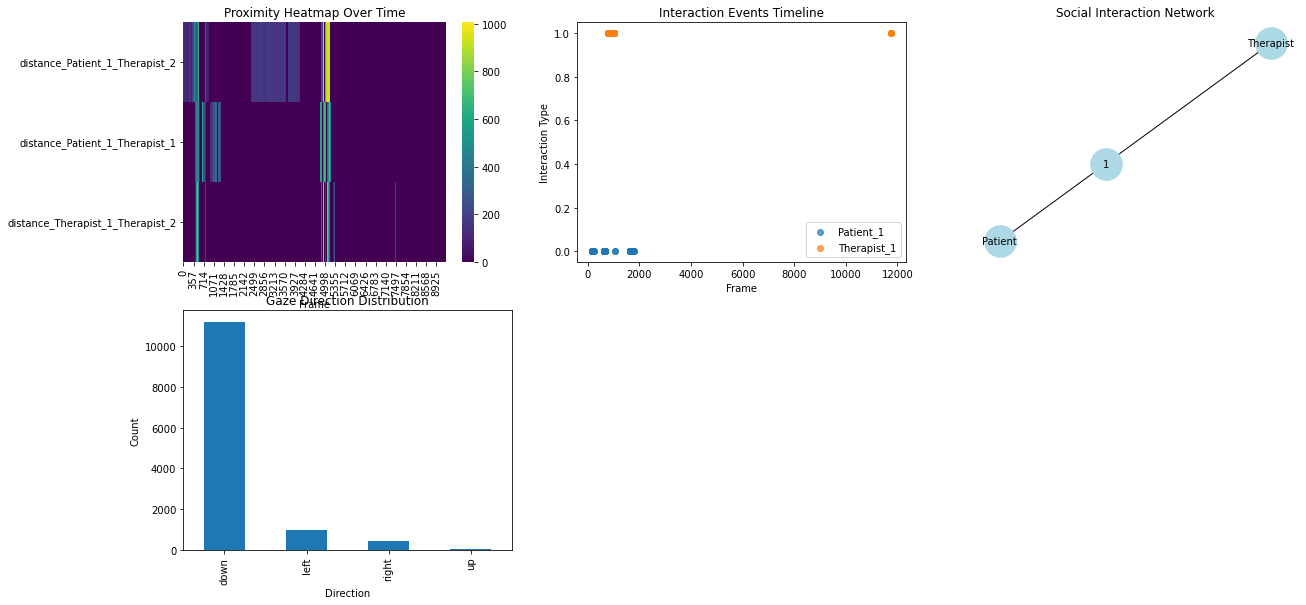

In [28]:
if __name__ == "__main__":
    # Load your joint position data
    joint_positions =  pd.read_csv("joint_positions.csv")
    joint_positions = joint_positions.drop('Unnamed: 0', axis=1)

    # Run enhanced analysis
    results, interactions = enhanced_main_analysis(joint_positions, object_detections)
    pass

In [20]:
joint_positions =  pd.read_csv("joint_positions.csv")

# Pivot for child joints (assuming 'Patient' == 'Patient_1' etc. are children)
joint_positions.reset_index(inplace=True)
child_df = joint_positions[joint_positions['Patient'].str.contains('Patient')]

child_pivot = child_df.pivot_table(index=['Patient', 'Frame'], 
                                   columns='Joint', 
                                   values=['X', 'Y']).reset_index()

# Flatten multi-index columns
child_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in child_pivot.columns.values]

# Pivot for therapist joints
therapist_df = joint_positions[joint_positions['Patient'].str.contains('Therapist')]

therapist_pivot = therapist_df.pivot_table(index=['Patient', 'Frame'], 
                                           columns='Joint', 
                                           values=['X', 'Y']).reset_index()

therapist_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in therapist_pivot.columns.values]

# Select therapist wrist positions (assuming single therapist or pick one)
therapist_wrist = therapist_pivot[['Frame', 'Patient', 'X_RWrist', 'Y_RWrist']].rename(
    columns={'X_RWrist': 'X_TherapistWrist', 'Y_RWrist': 'Y_TherapistWrist', 'Patient': 'Therapist'})


# Merge therapist wrist positions into child data by Frame (inner join)
merged_df = child_pivot.merge(therapist_wrist[['Frame', 'X_TherapistWrist', 'Y_TherapistWrist']], 
                              left_on='Frame', right_on='Frame', how='left')


# Calculate gaze vectors and angles similarly on merged_df...
merged_df['X_EyesMid'] = (merged_df['X_REye'] + merged_df['X_LEye']) / 2
merged_df['Y_EyesMid'] = (merged_df['Y_REye'] + merged_df['Y_LEye']) / 2

merged_df['gaze_vec_x'] = merged_df['X_EyesMid'] - merged_df['X_Nose']
merged_df['gaze_vec_y'] = merged_df['Y_EyesMid'] - merged_df['Y_Nose']

# Vector from nose to child's right wrist
merged_df['vec_nose_to_childWrist_x'] = merged_df['X_RWrist'] - merged_df['X_Nose']
merged_df['vec_nose_to_childWrist_y'] = merged_df['Y_RWrist'] - merged_df['Y_Nose']

# Vector from nose to therapist's wrist
merged_df['vec_nose_to_therapistWrist_x'] = merged_df['X_TherapistWrist'] - merged_df['X_Nose']
merged_df['vec_nose_to_therapistWrist_y'] = merged_df['Y_TherapistWrist'] - merged_df['Y_Nose']

In [28]:
def calculate_angle(row, vec_x, vec_y):
    a_x, a_y = row['gaze_vec_x'], row['gaze_vec_y']
    b_x, b_y = row[vec_x], row[vec_y]
    
    dot_product = a_x * b_x + a_y * b_y
    norm_a = np.sqrt(a_x**2 + a_y**2)
    norm_b = np.sqrt(b_x**2 + b_y**2)
    
    # Avoid division by zero
    if norm_a == 0 or norm_b == 0:
        return np.nan
    
    cos_theta = dot_product / (norm_a * norm_b)
    # Clip to valid range due to floating point errors
    cos_theta = np.clip(cos_theta, -1, 1)
    
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

merged_df['angle_to_childWrist'] = merged_df.apply(calculate_angle, axis=1,
                                                  vec_x='vec_nose_to_childWrist_x', vec_y='vec_nose_to_childWrist_y')

merged_df['angle_to_therapistWrist'] = merged_df.apply(calculate_angle, axis=1,
                                                      vec_x='vec_nose_to_therapistWrist_x', vec_y='vec_nose_to_therapistWrist_y')


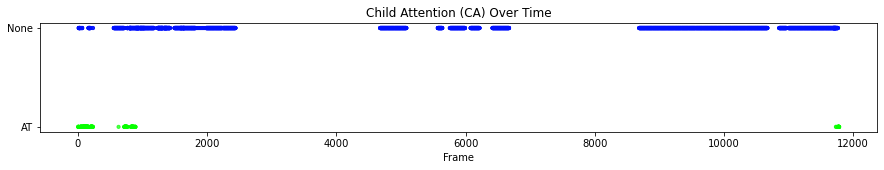

In [45]:
# Define threshold (degrees)
threshold = 60

# Initialize CA column as None or 'None'
merged_df['CA'] = 'None'

# Classify attention
merged_df.loc[merged_df['angle_to_childWrist'] < threshold, 'CA'] = 'AO'  # Attention on objects (child's hand)
merged_df.loc[merged_df['angle_to_therapistWrist'] < threshold, 'CA'] = 'AT'  # Attention on therapist

# If both angles are below threshold, prioritize therapist attention (or choose your logic)
merged_df.loc[(merged_df['angle_to_childWrist'] < threshold) & 
              (merged_df['angle_to_therapistWrist'] < threshold), 'CA'] = 'AT'

# Get unique categories from CA
categories = merged_df['CA'].unique()

# Generate a color palette with seaborn for all categories
palette = sns.color_palette("hsv", len(categories))
color_map = dict(zip(categories, palette))

# Map colors for plotting
colors = merged_df['CA'].map(color_map)

plt.figure(figsize=(15, 2))
plt.scatter(merged_df['Frame'], merged_df['CA'], c=colors, s=10, alpha=0.7)

plt.title('Child Attention (CA) Over Time')
plt.xlabel('Frame')
plt.yticks(categories)
plt.show()
# CAT (child attention on therapist): AT (attention on therapists)

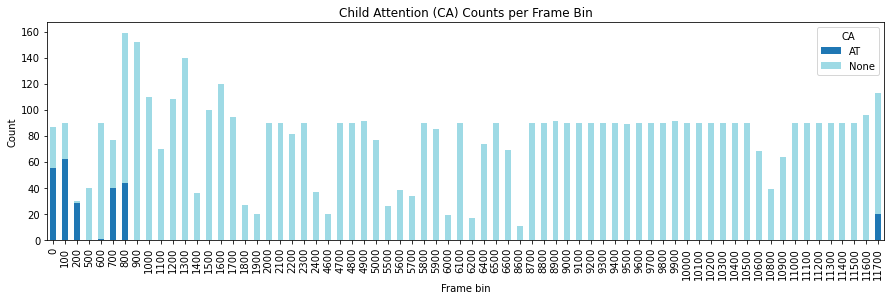

In [44]:
# Define bin size
bin_size = 100

# Create bins
merged_df['Frame_bin'] = (merged_df['Frame'] // bin_size) * bin_size

# Count categories per bin
counts = merged_df.groupby(['Frame_bin', 'CA']).size().unstack(fill_value=0)

# Plot stacked bar chart
counts.plot(kind='bar', stacked=True, figsize=(15, 4), colormap='tab20')

plt.title('Child Attention (CA) Counts per Frame Bin')
plt.xlabel('Frame bin')
plt.ylabel('Count')
plt.show()


1. More Detailed Interaction Analysis

Combine CA with child position (CP) or gaze (CG) to see when and how attention changes depending on posture or gaze direction.

For example: Does attention on therapist (AT) happen more when the child is sitting (CSI) or standing (CST)?

2. Detect Joint Attention Events

Look for simultaneous attention between child and therapist (joint eye contact).

Identify moments where both focus on the same object area (e.g., therapist’s hand and child’s hand proximity).

3. Temporal Patterns and Transitions

Analyze how child attention shifts over time — e.g., does attention on therapist increase after certain events or at specific times?

Use transition matrices to study probabilities of switching between attention states (None → AT and vice versa).

4. Predictive Modeling

Use joint positions and past attention states to predict future child attention.

Could apply simple models like logistic regression or more advanced like LSTM neural networks (sequence models).

5. Add Voice or Interaction Data

If you have voice or interaction labels (CS, TS, etc.), combine them to study correlations between attention and vocalizations.

6. Clustering and Profiling

Cluster frames or segments into behavioral profiles (e.g., “high attention,” “low attention,” “mixed”) to categorize interaction styles.

In [49]:
pose_classification = pd.read_csv("pose_classification.csv")
pose_classification.drop("Unnamed: 0", axis=1, inplace=True)

In [54]:
# Merge with pose_classification
combined_df = merged_df.merge(pose_classification[['Patient', 'Frame', 'Pose']],
                              on=['Patient', 'Frame'], how='left')

attention_by_pose = combined_df.groupby('Pose')['CA'].value_counts(normalize=True).unstack().fillna(0)
print(attention_by_pose)

CA              AT      None
Pose                        
Sitting   0.000000  1.000000
Standing  0.044851  0.955149


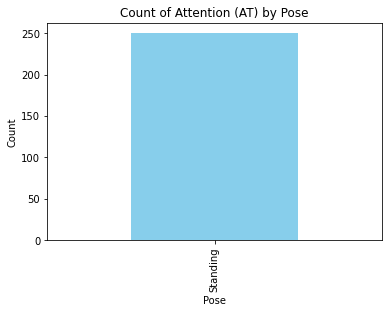

In [55]:
attention_counts = combined_df[combined_df['CA'] == 'AT'].groupby('Pose').size()

attention_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Attention (AT) by Pose')
plt.ylabel('Count')
plt.show()


In [56]:
# Map poses to numeric codes
pose_codes = {pose: i for i, pose in enumerate(combined_df['Pose'].unique())}
combined_df['Pose_code'] = combined_df['Pose'].map(pose_codes)


{'Standing': 0, 'Sitting': 1}


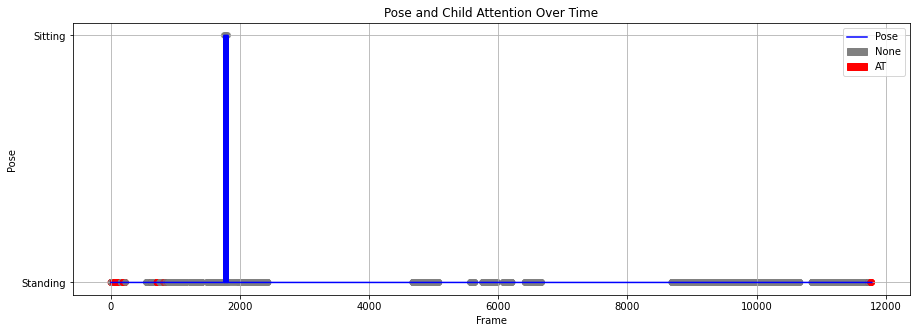

In [64]:
plt.figure(figsize=(15, 5))

# Plot Pose as a line
plt.plot(combined_df['Frame'].to_numpy(), combined_df['Pose_code'].to_numpy(), label='Pose', color='blue')

# Overlay Attention as colored dots
attention_colors = {'None': 'gray', 'AT': 'red'}
scatter = plt.scatter(combined_df['Frame'], combined_df['Pose_code'],
                      c=combined_df['CA'].map(attention_colors),
                      label='Child Attention (CA)', s=30, alpha=0.7)

# Add labels for Pose ticks
plt.yticks(list(pose_codes.values()), list(pose_codes.keys()))

plt.xlabel('Frame')
plt.ylabel('Pose')
plt.title('Pose and Child Attention Over Time')
plt.grid(True)

# Create custom legend for attention colors
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in attention_colors.items()]
plt.legend(handles=[plt.Line2D([0], [0], color='blue', label='Pose')] + legend_patches)

plt.show()
